In [1]:
import json
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import Preprocessor, ModelWorker
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# I. Acquire Training Data

In [2]:
train_df = pd.read_csv("output/Processed_Train.csv")
test_df = pd.read_csv("output/Processed_Test.csv")
print("Dimension of training data: ", train_df.shape)
print("Dimension of test data: ", test_df.shape)

train_df.head()

Dimension of training data:  (78458, 18)
Dimension of test data:  (19615, 16)


,Unique_ID,Views,Log_Views,Log_Comments,Log_Likes,Log_Popularity,Log_Followers,Categorical_Genre_0,Categorical_Genre_1,Categorical_Genre_2,Categorical_Genre_3,Categorical_Year_0,Categorical_Year_1,Categorical_Year_2,Categorical_Month_0,Categorical_Month_1,Categorical_Month_2,Categorical_Month_3
0,413890,14017,9.548097,1.609438,6.214608,4.584967,11.691607,0,1,0,0,0,0,1,0,1,0,0
1,249453,1918,7.559559,2.890372,3.912023,2.890372,7.669495,0,1,0,0,0,1,0,0,0,1,0
2,681116,9668,9.176680,2.484907,5.746203,4.521789,10.010052,0,1,0,0,1,0,0,0,1,0,0
3,387253,113036,11.635470,1.098612,7.783641,4.343805,12.883233,1,0,0,0,0,1,0,0,0,1,0
4,1428029,110024,11.608463,4.406719,8.016978,6.551080,12.211214,0,1,0,0,0,1,0,0,0,0,1


# II. Fit Machine Learning Models

In [3]:
# with open('output/boxcox_lambdas.json', 'r') as f:
#     boxcox_lambdas = json.load(f)
# print(boxcox_lambdas)

# scores = ['neg_root_mean_squared_error']
scores = ['neg_root_mean_squared_error']
features = list(test_df.columns)
features.remove('Unique_ID')
print(features)

['Log_Comments', 'Log_Likes', 'Log_Popularity', 'Log_Followers', 'Categorical_Genre_0', 'Categorical_Genre_1', 'Categorical_Genre_2', 'Categorical_Genre_3', 'Categorical_Year_0', 'Categorical_Year_1', 'Categorical_Year_2', 'Categorical_Month_0', 'Categorical_Month_1', 'Categorical_Month_2', 'Categorical_Month_3']


Remove outliers.

In [17]:
# train_df_outlier_removed = train_df[train_df['BC_Views'] / train_df['BC_Likes'] < 10]
# print(train_df_outlier_removed.shape)

quan_features = ['Log_Comments', 'Log_Likes', 'Log_Popularity', 'Log_Followers',
                 'Categorical_Year_0', 'Categorical_Year_1', 'Categorical_Year_2',
                 'Categorical_Month_0', 'Categorical_Month_1', 'Categorical_Month_2', 'Categorical_Month_3']
train_df_genre0 = train_df[train_df['Categorical_Genre_0'] == 1]
train_df_danceedm = train_df[train_df['Categorical_Genre_1'] == 1]
train_df_electronic = train_df[train_df['Categorical_Genre_2'] == 1]
train_df_genre3 = train_df[train_df['Categorical_Genre_3'] == 1]

## 2.1 Linear Regression

In [10]:
linear_reg_worker = ModelWorker(LinearRegression(), scores)
linear_reg_worker.fit(train_df_genre3, train_df_genre3['Log_Views'], quan_features)

RMSE:  0.882855


## 2.2 Lasso

In [7]:
lasso_worker = ModelWorker(Lasso(), scores)
lasso_worker.fit(train_df[features], train_df['Log_Views'], features)

RMSE:  0.964461


In [8]:
# lasso_params = {'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1]}
lasso_params = {'alpha': [0, 0.05, 0.1, 0.15, 0.2]}
lasso_grid, best_score = lasso_worker.tune(lasso_params, train_df[features], train_df['BC_Views'], 5)

# Tuning hyper-parameters for neg_root_mean_squared_error

Best parameters set found on development set:

{'alpha': 0}

Grid scores on development set:

-1.363 (+/-0.121) for {'alpha': 0}
-1.386 (+/-0.110) for {'alpha': 0.05}
-1.427 (+/-0.093) for {'alpha': 0.1}
-1.458 (+/-0.087) for {'alpha': 0.15}
-1.464 (+/-0.087) for {'alpha': 0.2}
Elapsed time: 7.6929 seconds



## 2.3 Random Forest

In [15]:
start_time = time.time()
rf_worker = ModelWorker(RandomForestRegressor(), scores)
rf_worker.fit(train_df, train_df['Log_Views'], features)
# rf_worker.fit(train_df_outlier_removed[quan_features], train_df_outlier_removed['BC_Views'], quan_features)
print(rf_worker.model)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

RMSE:  0.45197
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Elapsed time: 144.7024 seconds


In [21]:
start_time = time.time()
rf_worker = ModelWorker(RandomForestRegressor(), scores)
rf_worker.fit(train_df_genre3, train_df_genre3['Log_Views'], quan_features)
print(rf_worker.model)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

RMSE:  0.546138
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Elapsed time: 23.8132 seconds


In [5]:
rf_worker = ModelWorker(RandomForestRegressor(), scores, boxcox_lambdas)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Create the random grid
tuned_parameters = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': max_depth,
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'bootstrap': [True, False]}
rf_random, best_score = rf_worker.tune(tuned_parameters, train_df[features], train_df['BC_Views'], 5, False)
# model_metrics["Random Forest"] = round(best_score["accuracy"], 6)
# print(model_metrics)

# Tuning hyper-parameters for neg_root_mean_squared_error

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, score=-0.764, total= 2.3min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, score=-0.768, total= 2.3min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, score=-0.754, total= 2.3min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, score=-0.743, total= 2.4min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.3min remaining:    0.0s


[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, score=-0.743, total= 2.6min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min remaining:    0.0s


[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, score=-0.830, total= 1.0min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 13.0min remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, score=-0.840, total= 1.2min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.2min remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, score=-0.821, total=  58.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.2min remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, score=-0.824, total= 1.2min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.4min remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, score=-0.814, total=  59.4s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, score=-0.767, total= 2.4min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, score=-0.771, total= 2.3min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, score=-0.756, total= 2.3min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max

[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, score=-0.772, total= 1.0min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, score=-0.756, total= 1.0min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, score=-0.748, total= 1.1min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, score=-0.744, total= 1.1min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=s

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 149.3min finished


Best parameters set found on development set:

{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}

Grid scores on development set:

-0.754 (+/-0.021) for {'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
-0.826 (+/-0.017) for {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
-0.757 (+/-0.020) for {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
-0.936 (+/-0.015) for {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
-0.750 (+/-0.021) for {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
-0.735 (+/-0.020) for {'n_

Best performing parameters: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}

In [15]:
start_time = time.time()
rf_worker = ModelWorker(RandomForestRegressor(n_estimators=1000,
                                              min_samples_split=2,
                                              min_samples_leaf=2,
                                              max_features='auto',
                                              max_depth=110,
                                              bootstrap=True,
                                              n_jobs=3), scores, boxcox_lambdas)
rf_worker.fit(train_df_outlier_removed[features], train_df_outlier_removed['BC_Views'], features)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

RMSE:  0.699176
Elapsed time: 527.3588 seconds


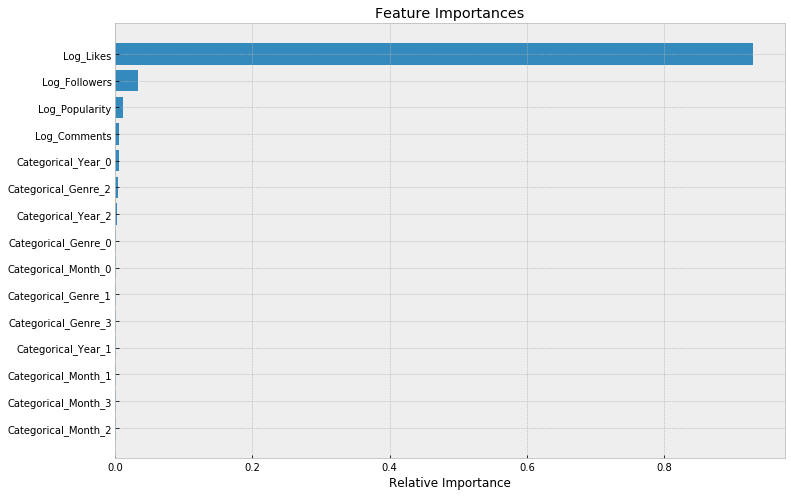

In [12]:
# importances = rf_random.best_estimator_.feature_importances_
importances = rf_worker.model.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 2.4 XGBoost

In [13]:
start_time = time.time()
xgb_worker = ModelWorker(XGBRegressor(), scores)
xgb_worker.fit(train_df[features], train_df['Log_Views'], features)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

RMSE:  0.590099
Elapsed time: 14.8389 seconds


# III. Predict on Test Data

In [10]:
start_time = time.time()
result = rf_worker.predict(train_df, train_df['Log_Views'], test_df, features)
result['Views'] = result['Views'].round().astype(int)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))
result.head()

Fitted model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Elapsed time: 34.6369 seconds


,Unique_ID,Log_Comments,Log_Likes,Log_Popularity,Log_Followers,Categorical_Genre_0,Categorical_Genre_1,Categorical_Genre_2,Categorical_Genre_3,Categorical_Year_0,Categorical_Year_1,Categorical_Year_2,Categorical_Month_0,Categorical_Month_1,Categorical_Month_2,Categorical_Month_3,Log_Views,Views
0,562546,3.295837,8.599510,4.779123,7.851272,1,0,0,0,0,0,1,1,0,0,0,12.589550,293475
1,907584,2.944439,6.605298,5.278115,11.955339,0,1,0,0,1,0,0,0,1,0,0,10.374450,32030
2,213013,2.944439,5.958425,4.574711,10.290347,0,1,0,0,1,0,0,0,0,0,1,9.589618,14611
3,340312,0.693147,5.963579,2.995732,13.591630,1,0,0,0,1,0,0,0,0,1,0,10.235989,27888
4,41854,0.000000,4.382027,0.693147,1.098612,0,0,0,1,0,0,1,0,0,1,0,8.430578,4584


In [24]:
result[['Unique_ID', 'Views']].to_excel('output/submission_20200113_1.xlsx', index=False)

In [22]:
train_df_genre0 = train_df[train_df['Categorical_Genre_0'] == 1]
train_df_danceedm = train_df[train_df['Categorical_Genre_1'] == 1]
train_df_electronic = train_df[train_df['Categorical_Genre_2'] == 1]
train_df_genre3 = train_df[train_df['Categorical_Genre_3'] == 1]

test_df_genre0 = test_df[test_df['Categorical_Genre_0'] == 1]
test_df_danceedm = test_df[test_df['Categorical_Genre_1'] == 1]
test_df_electronic = test_df[test_df['Categorical_Genre_2'] == 1]
test_df_genre3 = test_df[test_df['Categorical_Genre_3'] == 1]

In [23]:
start_time = time.time()
result1 = rf_worker.predict(train_df_genre0, train_df_genre0['Log_Views'], test_df_genre0, features)
result1['Views'] = result1['Views'].round().astype(int)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))
result2 = rf_worker.predict(train_df_danceedm, train_df_danceedm['Log_Views'], test_df_danceedm, features)
result2['Views'] = result2['Views'].round().astype(int)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))
result3 = rf_worker.predict(train_df_electronic, train_df_electronic['Log_Views'], test_df_electronic, features)
result3['Views'] = result3['Views'].round().astype(int)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))
result4 = rf_worker.predict(train_df_genre3, train_df_genre3['Log_Views'], test_df_genre3, features)
result4['Views'] = result4['Views'].round().astype(int)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

result = pd.concat([result1, result2, result3, result4])
print(result.shape)

Fitted model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Elapsed time: 7.4899 seconds
Fitted model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                 